<center>
    <div style="font-size: 24px; font-weight: 500; margin-bottom: -10px">
        Climat et Changement Climatique
    </div>
    <h3>Master</h3>
    <h5 style="margin-top: -5px">Sciences de l’Océan, de l’Atmosphère et du Climat</h5>
    <h1>Exam 2025-2026</h1>
    <h2>Modelling the relationship between warming and CO$_2$ emissions</h2>
</center>


## 1. Introduction

In this exercise, we propose to build a Simple Climate Model to examine the relationship between CO$_2$ emissions and the global warming by combining what we have learned about the carbon cycle (Part I) and the response of temperature to a pulse of radiative forcing using CMIP5 model outputs (Part II).


> **We ask you to send this notebook completed by your _own code_ and your _answers (french or english)_ to questions by email at romain.torres4@gmail.com**
> - rename the file with your name: **TP_SOAC-Exam_2025-2026-Name.ipynb**
> - you can use internet and your previous python codes from **Part I and Part II**
> - the exam should take **one hour** and is **individual** (one file per student)

As discussed during the class, you will be evaluated on your understanding of physical concepts about climate and your python code (figures, units, array manipulations, etc.)

## 2. Questions

You first need to import and load required modules:  

In [1]:
# header: importing useful modules and functions
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin

#### Question 1:

* *Use the impulse response function of CO$_2$ (Part I) to simulate the response of atmospheric CO$_2$ (in ppm) to a constant yearly emission of 10 GtCO$_2$ yr$^{-1}$ over 100 years.*
* _Plot the response of the model over time._

In [2]:
# WRITE YOUR CODE HERE

# definition of the parameters
a_C0, a_C1, a_C2, a_C3 = 0.2173, 0.2240, 0.2824, 0.2763
tau_C1, tau_C2, tau_C3 = 394.4, 36.54, 4.304             # given for time in year

# definition of the IRF
def irf_CO2(t):
    irf =  a_C0 + a_C1 * np.exp(-t/tau_C1) + \
    a_C2 * np.exp(-t/tau_C2) + a_C3 * np.exp(-t/tau_C3)
    return irf

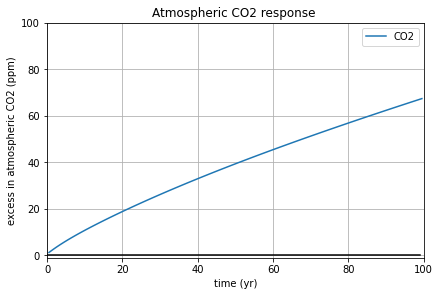

In [3]:
# WRITE YOUR CODE HERE

# convertion factor ppm --> GtCO2
k_CO2 = 2.13 * 44 / 12

# simulate the response of the climate to a constant 10 GtCO2 yr-1 emission over 100 years
t       = np.arange(100)
CO2_atm = np.convolve(10*np.ones_like(t)/k_CO2, irf_CO2(t))[:len(t)]

# plot the simulation
fig, ax1 = plt.subplots(1, 1, layout='constrained', figsize=(6, 4))

ax1.set_title("Atmospheric CO2 response ")

ax1.plot(0.5+t, CO2_atm, label='CO2')
ax1.plot(t, np.zeros_like(t), c='k')
ax1.set_ylabel('excess in atmospheric CO2 (ppm)')
ax1.set_xlabel('time (yr)')
ax1.set_xlim(0, 100)
ax1.set_ylim(-1, 100)
ax1.grid(True)
ax1.legend(loc=0)

#### Question 2:

Now we will try to model the surface temperature rise to this CO$_2$ forcings.
For that, we will use the output of the [Community Earth System Model](https://doi.org/10.1175/BAMS-D-12-00121.1) version 1.2 (CESM1).

The following python code load the model output for the _picontrol_ and _abrupt 4xCO2_ simulations.

In [4]:
# initalise empty dict
picontrol   = dict()
abrupt4xCO2 = dict()
som_4xCO2   = dict() 

# open simulation results
ctrl_datas = np.genfromtxt('./data/CESM1/CESM1-LME-picontrol_global.csv', 
                             skip_header=1, delimiter=',')
quad_datas = np.genfromtxt('./data/CESM1/CESM1b-4xCO2_global.csv', 
                             skip_header=1, delimiter=',')
som_datas  = np.genfromtxt('./data/CESM1/CESM1b-4xCO2-SOM_global.csv', 
                             skip_header=1, delimiter=',')

# yearly averaged variables
def moving_average(a, n=12):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    
    return ret[n - 1:] / n

# -- picontrol run
with open('./data/CESM1/CESM1-LME-picontrol_global.csv', newline='') as f:
  reader = csv.reader(f)
  header = next(reader)
    
for i, v in enumerate(header[1:]):
    var_name = v.split(' ')[0]
    picontrol[ var_name ] = moving_average(ctrl_datas[:,i+1])[5::12]

# -- abrupt4xCO2 run
with open('./data/CESM1/CESM1b-4xCO2_global.csv', newline='') as f:
  reader = csv.reader(f)
  header = next(reader)
    
for i, v in enumerate(header[1:]):
    var_name = v.split(' ')[0]
    abrupt4xCO2[ var_name ] = moving_average(quad_datas[:,i+1])[5::12]

# -- Slab Ocean Model run
with open('./data/CESM1/CESM1b-4xCO2-SOM_global.csv', newline='') as f:
  reader = csv.reader(f)
  header = next(reader)
    
for i, v in enumerate(header[1:]):
    var_name = v.split(' ')[0]
    som_4xCO2[ var_name ] = moving_average(som_datas[:,i+1])[5::12]

Yearly averaged datas are stored in python dictionaries `picontrol`, `abrupt4xCO2` and `som_4xCO2`. 
You can access to the variable with the following code:
```python
# picontrol
picontrol['FSNT'] # Net solar flux at the top of the model 
picontrol['FLNT'] # Net longwave flux at the top of the model
picontrol['TS']   # Global average of the surface temperature

# abrupt 4xCO2
abrupt4xCO2['FSNT'] # Net solar flux at the top of the model 
abrupt4xCO2['FLNT'] # Net longwave flux at the top of the model
abrupt4xCO2['TS']   # Global average of the surface temperature
```

* *Using the method of [Gregory et al. (2004)](https://doi.org/10.1029/2003GL018747) you have learned (Part II), find the equilibrium climate sensitivity in the abrupt 4xCO2 experiment (ECS$_{\text{4xCO}_2}$).*

Note that since _picontrol_ simulation is already in a steady state, the pre-industrial climate state (e.g. surface temperature and radiative fluxes) can be deduced from temporal means.

Text(0.5, 0.95, 'Warming and radiative imbalance in an abrupt 4xCO2 experiment using CESM1.2')

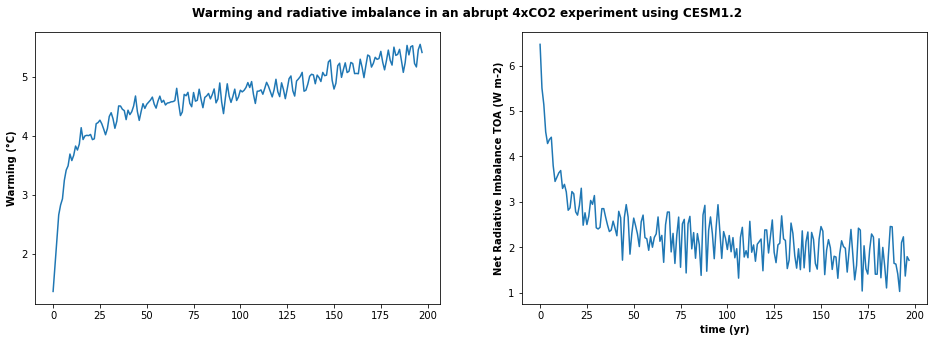

In [5]:
# create net radiative budget variable
netrad_ctrl = picontrol['FSNT']   - picontrol['FLNT']
netrad_quad = abrupt4xCO2['FSNT'] - abrupt4xCO2['FLNT']

# Compute Radiative Imbalance and Warming
imbalance   = netrad_quad       - netrad_ctrl.mean()
warming     = abrupt4xCO2['TS'] - picontrol['TS'].mean()

# NET IMBALANCE vs TEMPERATURE
fig, ax = plt.subplots(1, 2, figsize=(16,5))

ax[0].plot(warming)
ax[0].set_ylabel('Warming (°C)', fontweight="bold")
    
ax[1].plot(imbalance)
ax[1].set_xlabel('time (yr)', fontweight="bold")
ax[1].set_ylabel('Net Radiative Imbalance TOA (W m-2)', fontweight="bold")
    
fig.suptitle("Warming and radiative imbalance in an abrupt 4xCO2 experiment using CESM1.2", fontweight="bold", y=0.95)

-0.7558403141653447 6.399926704379216


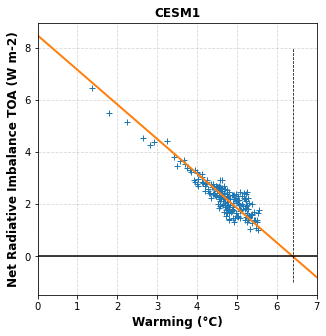

In [6]:
# define function to minimize  
def err(var):
    # function to minimize: D_T = -1/lambda * D_R + T_eq
    #   --> var[0] = -1/lambda;  var[1] = T_eq
    D_T = var[0] * (imbalance) + var[1]
    return sum(( D_T - warming )**2)
    
coeff, T4x = fmin(err, [-1.,3.], disp=False)
print(coeff, T4x)

# plot linear regression
fig, ax = plt.subplots(1,1, figsize=(5,5))

ax.plot(warming, imbalance, marker='+',ls='none')
ax.plot(np.arange(0,8), 1/coeff*np.arange(0,8)-1/coeff*T4x,lw=2) 
ax.plot(np.arange(0,8),  0*np.arange(0,8), c='k')
ax.plot(T4x*np.ones(30), np.linspace(-1,8,30), c='k', ls='--', lw=0.75)


ax.set_title('CESM1', fontweight="bold")
ax.set_xlabel('Warming (°C)',                        fontsize=12, fontweight="bold")
ax.set_ylabel('Net Radiative Imbalance TOA (W m-2)', fontsize=12, fontweight="bold")
ax.set_xlim(0, 7)
        
ax.grid("on", alpha=0.5, ls="--")

#### Question 3:

The method employed extrapolate the results from fully coupled atmosphere-ocean climate models. This extrapolation is necessary since these models take millennia to equilibriate. 

Another approach is the use of a thermodynamic "slab" ocean model (SOM) rather than a full dynamical ocean in abrupt CO$_2$ increase experiments to eliminate the long time scales produced by the slow deep-ocean responses to warming. The SOM experiments equilibrate in decades rather than centuries, yielding a SOM-based estimate of ECS (ECS-SOM).

* *From the python dictionary `som_4xCO2`, propose an estimation for ECS-SOM to an abrupt 4xCO2 concentration.*

You can access to the variable with the following code:
```python
# SOM 4xCO2
som_4xCO2['FSNT'] # Net solar flux at the top of the model 
som_4xCO2['FLNT'] # Net longwave flux at the top of the model
som_4xCO2['TS']   # Global average of the surface temperature
```

8.248215968247715


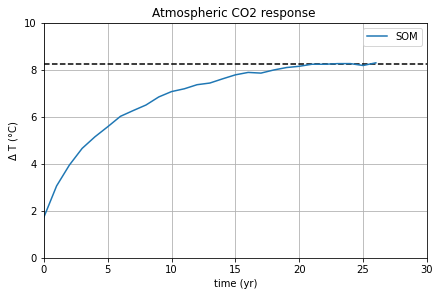

In [7]:
DTS      = som_4xCO2['TS'] - picontrol['TS'].mean()
T4x_som  = DTS[-3:].mean()
print(T4x_som)

# plot the temperature change
fig, ax1 = plt.subplots(1, 1, layout='constrained', figsize=(6, 4))

ax1.set_title("Atmospheric CO2 response ")

ax1.plot(np.arange(31), T4x_som*np.ones(31), c='k', ls='--')
ax1.plot(np.arange(len(DTS)), DTS, label='SOM')
ax1.set_ylabel(r'$\Delta$ T (°C)')
ax1.set_xlabel('time (yr)')
ax1.set_xlim(0, 30)
ax1.set_ylim(0, 10)
ax1.grid(True)
ax1.legend(loc=0)

* *How different are ECS-SOM and ECS$_{\text{4xCO}_2}$ ? From your knowledge of climate system, what can explain the difference ?*

<font color="blue">
As the SOM with speciﬁed lateral and deep ocean heat ﬂux pattern comes rapidly (after decades) to equilibrium, the ECS-SOM is simply the temperature change at the end of the simulation (here, ECS-SOM=8.2 K).

In question 2, the ECS is computed from a linear fit to extrapolate the climate response from a fully coupled climate model (with the full ocean component) to the forcing induced by the increase in CO$_2$ concentration. We found ECS$_{\text{4xCO}_2}$=6.4 K.

However, the linear extrapolation implies a constant sensitivity parameter $\lambda$=1.32 all along the simulation. 
This does not take into account some climate feedbacks that are not necessarily linear with increasing temperature.
ECS computed from this extrapolation are known to understimate (~15%) the ECS computed from longer simulations.

On the other hand, SOM has the uncertainty of estimating the ECS with a fundamentally different ocean component. In particular ocean heat flux and heat transport can be different that one simulated by a deep ocean model.


</font>

#### Question 4:

* *Using the ECS in the abrupt 4xCO2 simulation, find the parameters $a_{T,1}$, $a_{T,2}$, $\tau_{T,1}$ and $\tau_{T,2}$ to fit the function bellow with the simulation outputs*

$$ tas(t) = \text{ECS}_{\text{4xCO}_2} \left[1 - a_{T,1}\exp(\frac{-t}{\tau_{T,1}}) - a_{T,2}\exp(\frac{-t}{\tau_{T,2}})\right]$$

In [8]:
# fit dynamical parameters for the abrupt 4xCO2 run
t = np.arange(0, len(abrupt4xCO2['TS'])) + 0.5

def err(var):
    D_T = T4x * (1 - var[0]*np.exp(-t/var[1]) - (1-var[0])*np.exp(-t/var[2]))
    return sum(( D_T - warming )**2)  # RMSE (Sum of error squared)

a_T1, tau_T1, tau_T2 = fmin(err, [0.5,2,200], disp=False)
a_T2 = 1-a_T1

a_T1, a_T2, tau_T1, tau_T2

(np.float64(0.6108861238412717),
 np.float64(0.3891138761587283),
 np.float64(3.44813859749913),
 np.float64(233.00081317584335))

* *Convert the CO$_2$ concentration into radiative Forcing F$_{\text{CO}_2}$ (see Part II) and using the derivative of the tas function (which is the IRF), compute and show the warming response over time to this constant emission.*

__Note__: the warming response is the convolution product between the IRF for tas and F$_{\text{CO}_2}$ (think about the units) 

__Help__: you can take the following value for the parameters

```python
a_T1   = 0.61
a_T2   = 0.39think
tau_T1 = 3.44
tau_T2 = 233.
```

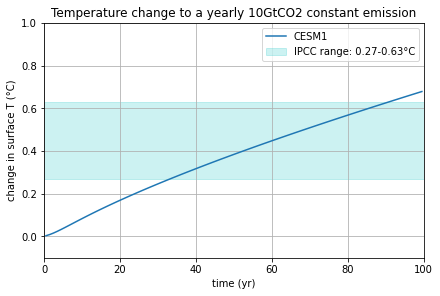

In [9]:
# WRITE YOUR CODE HERE
def irf_TAS(t):
    return T4x * (a_T1/tau_T1*np.exp(-t/tau_T1) + a_T2/tau_T2*np.exp(-t/tau_T2))

CO2_0 = 278
F_CO2 = 5.35*np.log( (CO2_0 + CO2_atm)/CO2_0 )

T_to_RF = -1/coeff * T4x # required to get degree after the convolution product

t   = np.arange(len(CO2_atm))
DTS = np.convolve(F_CO2, 1/T_to_RF*irf_TAS(t))[:len(CO2_atm)]

# plot external forcing due to CO2 concentration rise
fig, ax1 = plt.subplots(1, 1, layout='constrained', figsize=(6, 4))

ax1.set_title("Temperature change to a yearly 10GtCO2 constant emission")

ax1.plot(0.5+t, DTS, label='CESM1')
ax1.fill_between([0, 150], 0.27, 0.63, alpha=0.2, color="c", label="IPCC range: 0.27-0.63°C")

ax1.set_ylabel('change in surface T (°C)')
ax1.set_xlabel('time (yr)')
ax1.set_xlim(0, 100)
ax1.set_ylim(-0.1, 1)
ax1.grid(True)
ax1.legend(loc=0)

The recent IPCC report gives a likely range of TCRE (transient surface temperature change per 1000 GtCO$_2$ cumulative emissions) of 0.27-0.63 ◦ C (IPCC, SPM, 2021).

* *Discuss your outcome with this range.*
* *What could explain this large range ? Do you expect another result with different models ?*

<font color="blue">
    
In our idealised constant 10GtCO$_2$ emission scenario, the 1000 GtCO$_2$ cumulative emission arises after 100 years.
At this time, our model indicates a global surface temperature rise of 0.68 K which outside of the IPCC range but not so far (+0.05 K).

The large range given in the IPCC could be explained by the use of multiple climate models, all making different numerical and modelling choices. In particular, climate models cannot fully resolve small-scale processes, such as those related to clouds – which are thought to be important for climate sensitivity.

Thus, if we reconduct this notebook with a different climate model (for instance one of the CMIP5 list used during Part II), one can expect a different result in temperature rise despite a very similar trend.
</font>